In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from keras.models import Sequential, clone_model
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [2]:
class DQN:
    
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.env_for_evaluation = gym.make('CartPole-v1')
        
        self.LEARNING_RATE = 0.01
        self.MEMORY_SIZE = 8192
        self.BATCH_SIZE = 256
        self.EPISODES = 1000
        self.EPSILON = 0.1
        self.EPSILON_DECAY_RATE = 1.0 / (100 * self.EPISODES)
        self.GAMMA = 1.0
        
        self.observation_space = self.env.observation_space.shape
        self.action_space = self.env.action_space.n
        
        self.memory = deque(maxlen=self.MEMORY_SIZE)
        
        self.model = self.build_model()
#         self.model_copy = None


    def build_model(self):
        model = Sequential()
        model.add(Dense(12, input_shape=self.observation_space, activation="relu"))
        model.add(Dense(12, activation="relu"))
        model.add(Dense(self.action_space, activation="linear"))
        model.compile(loss="mse", optimizer=RMSprop(lr=self.LEARNING_RATE))
        return model
    
    def remember(self, experience):
        self.memory.append(experience)
        
    def reshape_state(self, s):
        return np.array(s).reshape((1, 4))
    
    def choose_max_action(self, s):
        q_values = self.model.predict(self.reshape_state(s))[0]
        return np.argmax(q_values)
    
    def choose_action(self, s):
        if np.random.random() < self.EPSILON:
            return self.env.action_space.sample()
        else:
            return self.choose_max_action(s)
    
    def get_random_minibatch(self):
        idx = np.random.choice(len(self.memory), size=self.BATCH_SIZE, replace=False)
        return np.array(self.memory)[idx]

    def experience_replay(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        
        minibatch = self.get_random_minibatch()
        
        states = np.stack(minibatch[:, 0], axis=0)
        actions = minibatch[:, 1]
        rewards = minibatch[:, 2]
        next_states = np.stack(minibatch[:, 3], axis=0)
        done = minibatch[:, 4]
      
        predictions_s = self.model.predict(states)
        predictions_for_next_s = self.model.predict(next_states)
        
        estimated_max_q_values = rewards + self.GAMMA * np.max(predictions_for_next_s, axis=1)
        
        for i in range(len(predictions_s)):
            # Terminal states have no future, so we should set their Q-value to their immediate reward.
            predictions_s[i][actions[i]] = estimated_max_q_values[i] if done[i] is False else rewards[i]

        self.model.fit(states, predictions_s, verbose=0, epochs=1)
            
    
    def evaluate(self):
        s = self.env_for_evaluation.reset()
        reward_sum = 0
        done = False
        while not done:
            a = self.choose_max_action(s)
            s, reward, done, _ = self.env_for_evaluation.step(a) 
            reward_sum += reward
        return reward_sum
    
    def train(self):
        eval_history = deque()
        avg_eval_history = deque()
        run_history = deque()
        
        s = self.env.reset()
        
        last_evals = deque(maxlen=100)
        run_reward = 0
        
        for e in range(self.EPISODES):
                   
#             if e%5 == 0:
#                 self.model_copy = clone_model(self.model)
#                 self.model_copy.set_weights(self.model.get_weights())
            
            for i in range(100):
                
                a = self.choose_action(s)
                s_next, reward, done, _ = self.env.step(a)
                
                experience = (s, a, reward, s_next, done)
                self.remember(experience)
                
                s = s_next
                run_reward += reward
                
                if done:
                    s = self.env.reset()
                    run_history.append(run_reward)
                    run_reward = 0
                
#             self.EPSILON *= (1 - self.EPSILON_DECAY_RATE)
            
            self.experience_replay()
        
            evaluation = self.evaluate()
            print(f"Episode: {e}, Total reward after evaluation: {round(evaluation, 2)}")
            
            eval_history.append(evaluation)
            last_evals.append(evaluation)
            avg_eval_history.append(np.mean(last_evals))           
            
        return eval_history, avg_eval_history, run_history

Episode: 0, Total reward after evaluation: 55.0
Episode: 1, Total reward after evaluation: 91.0
Episode: 2, Total reward after evaluation: 39.0
Episode: 3, Total reward after evaluation: 51.0
Episode: 4, Total reward after evaluation: 72.0
Episode: 5, Total reward after evaluation: 50.0
Episode: 6, Total reward after evaluation: 62.0
Episode: 7, Total reward after evaluation: 49.0
Episode: 8, Total reward after evaluation: 45.0
Episode: 9, Total reward after evaluation: 42.0
Episode: 10, Total reward after evaluation: 119.0
Episode: 11, Total reward after evaluation: 60.0
Episode: 12, Total reward after evaluation: 90.0
Episode: 13, Total reward after evaluation: 60.0
Episode: 14, Total reward after evaluation: 41.0
Episode: 15, Total reward after evaluation: 50.0
Episode: 16, Total reward after evaluation: 33.0
Episode: 17, Total reward after evaluation: 36.0
Episode: 18, Total reward after evaluation: 42.0
Episode: 19, Total reward after evaluation: 38.0
Episode: 20, Total reward aft

Episode: 166, Total reward after evaluation: 116.0
Episode: 167, Total reward after evaluation: 102.0
Episode: 168, Total reward after evaluation: 87.0
Episode: 169, Total reward after evaluation: 94.0
Episode: 170, Total reward after evaluation: 87.0
Episode: 171, Total reward after evaluation: 106.0
Episode: 172, Total reward after evaluation: 73.0
Episode: 173, Total reward after evaluation: 82.0
Episode: 174, Total reward after evaluation: 81.0
Episode: 175, Total reward after evaluation: 83.0
Episode: 176, Total reward after evaluation: 76.0
Episode: 177, Total reward after evaluation: 107.0
Episode: 178, Total reward after evaluation: 78.0
Episode: 179, Total reward after evaluation: 100.0
Episode: 180, Total reward after evaluation: 75.0
Episode: 181, Total reward after evaluation: 73.0
Episode: 182, Total reward after evaluation: 90.0
Episode: 183, Total reward after evaluation: 126.0
Episode: 184, Total reward after evaluation: 62.0
Episode: 185, Total reward after evaluation:

Episode: 330, Total reward after evaluation: 178.0
Episode: 331, Total reward after evaluation: 134.0
Episode: 332, Total reward after evaluation: 150.0
Episode: 333, Total reward after evaluation: 151.0
Episode: 334, Total reward after evaluation: 121.0
Episode: 335, Total reward after evaluation: 154.0
Episode: 336, Total reward after evaluation: 132.0
Episode: 337, Total reward after evaluation: 132.0
Episode: 338, Total reward after evaluation: 159.0
Episode: 339, Total reward after evaluation: 197.0
Episode: 340, Total reward after evaluation: 146.0
Episode: 341, Total reward after evaluation: 176.0
Episode: 342, Total reward after evaluation: 63.0
Episode: 343, Total reward after evaluation: 129.0
Episode: 344, Total reward after evaluation: 150.0
Episode: 345, Total reward after evaluation: 142.0
Episode: 346, Total reward after evaluation: 120.0
Episode: 347, Total reward after evaluation: 162.0
Episode: 348, Total reward after evaluation: 159.0
Episode: 349, Total reward after

Episode: 491, Total reward after evaluation: 285.0
Episode: 492, Total reward after evaluation: 187.0
Episode: 493, Total reward after evaluation: 500.0
Episode: 494, Total reward after evaluation: 500.0
Episode: 495, Total reward after evaluation: 305.0
Episode: 496, Total reward after evaluation: 200.0
Episode: 497, Total reward after evaluation: 318.0
Episode: 498, Total reward after evaluation: 366.0
Episode: 499, Total reward after evaluation: 191.0
Episode: 500, Total reward after evaluation: 173.0
Episode: 501, Total reward after evaluation: 212.0
Episode: 502, Total reward after evaluation: 268.0
Episode: 503, Total reward after evaluation: 500.0
Episode: 504, Total reward after evaluation: 437.0
Episode: 505, Total reward after evaluation: 440.0
Episode: 506, Total reward after evaluation: 500.0
Episode: 507, Total reward after evaluation: 492.0
Episode: 508, Total reward after evaluation: 267.0
Episode: 509, Total reward after evaluation: 394.0
Episode: 510, Total reward afte

Episode: 652, Total reward after evaluation: 500.0
Episode: 653, Total reward after evaluation: 263.0
Episode: 654, Total reward after evaluation: 271.0
Episode: 655, Total reward after evaluation: 500.0
Episode: 656, Total reward after evaluation: 330.0
Episode: 657, Total reward after evaluation: 500.0
Episode: 658, Total reward after evaluation: 435.0
Episode: 659, Total reward after evaluation: 500.0
Episode: 660, Total reward after evaluation: 500.0
Episode: 661, Total reward after evaluation: 260.0
Episode: 662, Total reward after evaluation: 500.0
Episode: 663, Total reward after evaluation: 335.0
Episode: 664, Total reward after evaluation: 500.0
Episode: 665, Total reward after evaluation: 500.0
Episode: 666, Total reward after evaluation: 500.0
Episode: 667, Total reward after evaluation: 500.0
Episode: 668, Total reward after evaluation: 339.0
Episode: 669, Total reward after evaluation: 294.0
Episode: 670, Total reward after evaluation: 500.0
Episode: 671, Total reward afte

Episode: 813, Total reward after evaluation: 500.0
Episode: 814, Total reward after evaluation: 500.0
Episode: 815, Total reward after evaluation: 500.0
Episode: 816, Total reward after evaluation: 500.0
Episode: 817, Total reward after evaluation: 306.0
Episode: 818, Total reward after evaluation: 338.0
Episode: 819, Total reward after evaluation: 500.0
Episode: 820, Total reward after evaluation: 500.0
Episode: 821, Total reward after evaluation: 500.0
Episode: 822, Total reward after evaluation: 500.0
Episode: 823, Total reward after evaluation: 500.0
Episode: 824, Total reward after evaluation: 500.0
Episode: 825, Total reward after evaluation: 500.0
Episode: 826, Total reward after evaluation: 284.0
Episode: 827, Total reward after evaluation: 280.0
Episode: 828, Total reward after evaluation: 500.0
Episode: 829, Total reward after evaluation: 500.0
Episode: 830, Total reward after evaluation: 500.0
Episode: 831, Total reward after evaluation: 500.0
Episode: 832, Total reward afte

Episode: 974, Total reward after evaluation: 500.0
Episode: 975, Total reward after evaluation: 500.0
Episode: 976, Total reward after evaluation: 371.0
Episode: 977, Total reward after evaluation: 414.0
Episode: 978, Total reward after evaluation: 500.0
Episode: 979, Total reward after evaluation: 365.0
Episode: 980, Total reward after evaluation: 500.0
Episode: 981, Total reward after evaluation: 360.0
Episode: 982, Total reward after evaluation: 357.0
Episode: 983, Total reward after evaluation: 500.0
Episode: 984, Total reward after evaluation: 333.0
Episode: 985, Total reward after evaluation: 500.0
Episode: 986, Total reward after evaluation: 349.0
Episode: 987, Total reward after evaluation: 424.0
Episode: 988, Total reward after evaluation: 500.0
Episode: 989, Total reward after evaluation: 373.0
Episode: 990, Total reward after evaluation: 447.0
Episode: 991, Total reward after evaluation: 363.0
Episode: 992, Total reward after evaluation: 500.0
Episode: 993, Total reward afte

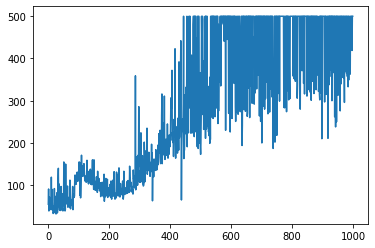

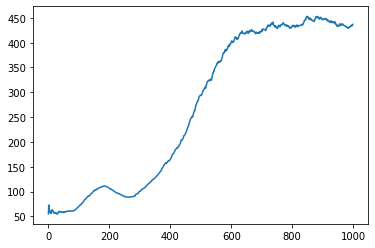

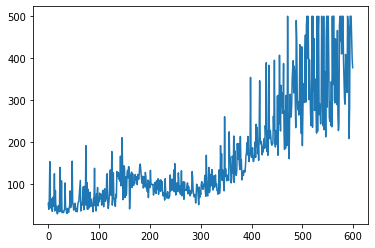

In [3]:
dqn = DQN()
eval_history, avg_eval_history, run_history = dqn.train()

plt.plot(eval_history)
plt.show()

plt.plot(avg_eval_history)
plt.show()

plt.plot(run_history)
plt.show()